Number of categories = 50


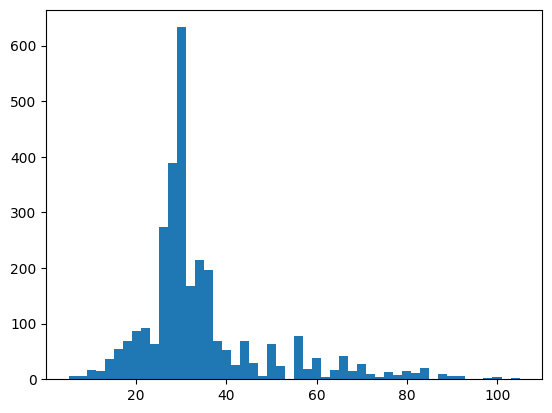

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from set_transformer.main import read_ogt_data

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_train_column_names, y_train, X_test, X_test_column_names, y_test, num_classes, categories_linspace = read_ogt_data()

print(f"Number of categories = {num_classes}")

ind_point = 20
folds = range(5)
file_names_cv = [f"prediction_probabilities_cross_valid_fold_{fold}_SetTransformer_indPoints_{ind_point}" for fold in folds]


y_train_to_temp = []
for categ_i in y_train.tolist():
    categ_i = int(categ_i)
    mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
    y_train_to_temp.append(mid_bin_temp)

hist = plt.hist(y_train_to_temp, bins = num_classes)

In [21]:
# Read your dataframe (for example from a CSV file)
def read_and_plot(filename, plot_flag=False):
    df = pd.read_csv(f"set_transformer/resuls_SetTransformer/{filename}.csv",sep="\t")  # Replace with your file path
    y_act_to_temp = []
    for categ_i in df['y_actual']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        y_act_to_temp.append(mid_bin_temp)
    predict_to_temp = []
    for categ_i in df['prediction']:
        mid_bin_temp = ((categories_linspace[categ_i-1] + categories_linspace[categ_i])/2)
        predict_to_temp.append(mid_bin_temp)
    if plot_flag:
        plt.scatter(y_act_to_temp, predict_to_temp, marker='o', alpha = 0.3, c = "tab:blue", s=13)#, linestyle='-', color='b')
    
    return min(y_act_to_temp), max(y_act_to_temp), min(predict_to_temp), max(predict_to_temp), y_act_to_temp, predict_to_temp

PCC : 0.8420921662554834


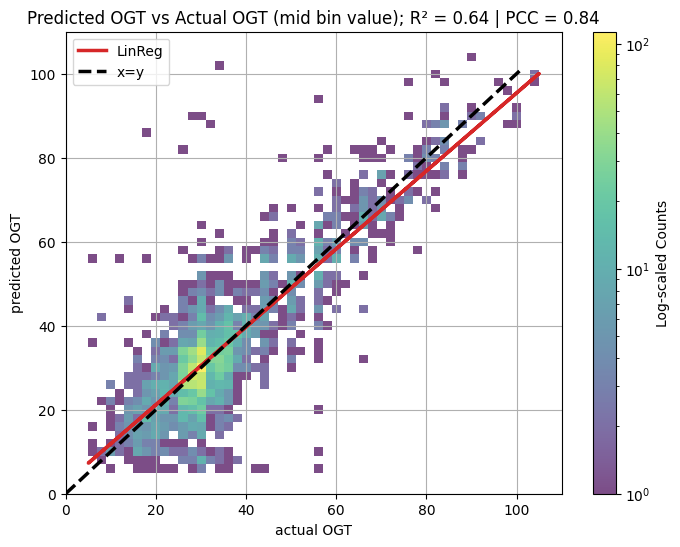

In [22]:
from matplotlib.colors import LogNorm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

y_act_to_temp_tot = []
predict_to_temp_tot = []

for file in file_names_cv:
    x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file, plot_flag=False)
    y_act_to_temp_tot += y_act_to_temp
    predict_to_temp_tot += predict_to_temp

# Calculate R^2
r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)

pcc_scipy, p_value = pearsonr(y_act_to_temp_tot, predict_to_temp_tot)
print(f"PCC : {pcc_scipy}")

# Fit a linear regression model
model = LinearRegression()

x = np.array(y_act_to_temp_tot).reshape(-1, 1)
y = np.array(predict_to_temp_tot)
model.fit(x, y)

# Get predictions for the best-fit line
y_pred = model.predict(x)


# Create the figure
plt.figure(figsize=(8, 6))
plt.grid(True)

# Plot the best-fit line
plt.plot(x, y_pred, color='tab:red', linewidth=2.5, label=f'LinReg')


# Create a 2D histogram with log scaling for counts
hist = plt.hist2d(
    y_act_to_temp_tot,
    predict_to_temp_tot,
    bins=num_classes,
    norm=LogNorm(),
    cmap='viridis', alpha = 0.7
)
plt.plot([0,x_max],[0,x_max], c = "black", label = "x=y", linestyle='--', linewidth=2.5)
plt.xlim([0,110])
plt.ylim([0,110])
# Add a color bar with the label
cbar = plt.colorbar(hist[3], label="Log-scaled Counts")

# Add labels and a title
plt.title(f'Predicted OGT vs Actual OGT (mid bin value); R² = {round(r2,2)} | PCC = {round(pcc_scipy,2)}')
plt.xlabel('actual OGT')
plt.ylabel('predicted OGT')
plt.legend()
# Show the plot
plt.show()


In [23]:
TODO: ADD ERROR

SyntaxError: invalid syntax (369451944.py, line 1)

In [ ]:
num_ind_arr = [10, 12, 14, 16, 18, 20]#[1, 2, 4, 6, 8, 10, 12, 14, 16, 18] [2, 4, 6, 8, 
r2_arr = []

file_names_cv_arr = []
for ind_point in num_ind_arr:
    file_names_cv = [f"prediction_probabilities_cross_valid_fold_0_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_1_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_2_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_3_SetTransformer_indPoints_{ind_point}", f"prediction_probabilities_cross_valid_fold_4_SetTransformer_indPoints_{ind_point}"]
    y_act_to_temp_tot = []
    predict_to_temp_tot = []
    for file in file_names_cv:
        x_min, x_max, y_min, y_max, y_act_to_temp, predict_to_temp = read_and_plot(file)
        y_act_to_temp_tot += y_act_to_temp
        predict_to_temp_tot += predict_to_temp
    r2 = r2_score(y_act_to_temp_tot, predict_to_temp_tot)
    r2_arr.append(r2)

plt.figure()
plt.scatter(num_ind_arr, r2_arr, s=50)
plt.plot(num_ind_arr, r2_arr, alpha = 0.3)
plt.xticks(num_ind_arr, labels=num_ind_arr)
plt.xlabel("number of inducing points")
plt.ylabel("R²")
plt.title("Accuracy as a function |of the number of inducing points")
plt.ylim([0.3,0.8])

PCA Loadings (components): (2, 3165)
     K07461    K00243    K00185    K01890    K00406    K03088    K07240  \
0  0.005819  0.006199 -0.004449 -0.004888  0.013707  0.001496  0.010502   
1 -0.011091 -0.021273 -0.016666  0.005992 -0.008156  0.023903  0.018619   

     K22391    K03657    K01809  ...    K00972    K11858    K11187    K10413  \
0 -0.014224 -0.007168 -0.008536  ... -0.000703 -0.000051 -0.001452 -0.000624   
1  0.007259  0.061042  0.028890  ...  0.001206  0.000409 -0.001996  0.000065   

     K05692    K21418    K12260    K19949    K18134    K14326  
0  0.000341 -0.000069  0.000022 -0.000433  0.000038  0.000012  
1  0.000139  0.000113  0.000450  0.000261 -0.000751  0.000763  

[2 rows x 3165 columns]


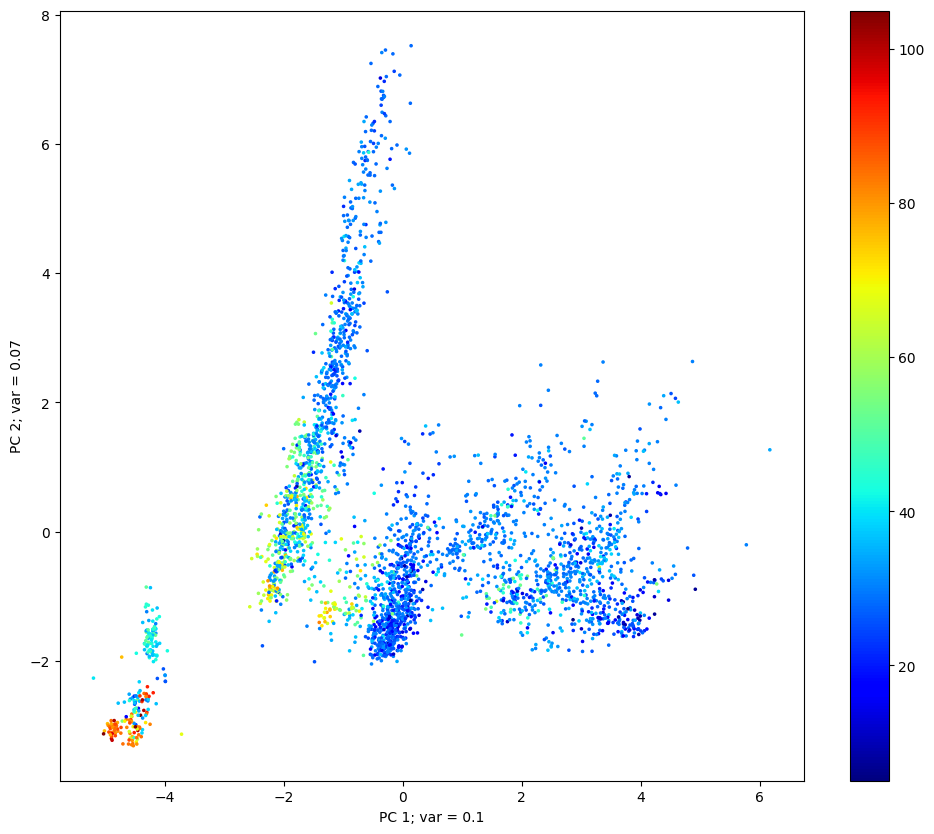

In [46]:
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import PCA

n_compon=2
# Run PCA on the X-data
pca = PCA(n_components=n_compon)
X_train_pca = pca.fit_transform(X_train.cpu())

explained_variance_ratio = pca.explained_variance_ratio_

loadings = pca.components_
print("PCA Loadings (components):", loadings.shape)

# If you want to map the loadings to your feature names (for example, gene names)
# You can use a DataFrame for better readability

# Assuming feature_names is a list of feature names (e.g., gene names)
feature_names = [f"{cog_i}" for cog_i in X_test_column_names]  # Replace with actual names if you have them X_test_column_names
loadings_df = pd.DataFrame(loadings, columns=feature_names)
print(loadings_df)

plt.figure(figsize=(12, 10))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=1, s = 2.5, c=y_train_to_temp, cmap='jet')
plt.xlabel(f"PC 1; var = {round(explained_variance_ratio[0],2)}")
plt.ylabel(f"PC 2; var = {round(explained_variance_ratio[1],2)}")
plt.colorbar()

In [50]:
# Plotting loadings for the first principal component
# plt.figure(figsize=(10, 6))
# plt.barh(loadings_df.columns, loadings_df.iloc[0].abs())
# plt.title('Feature Importance for PC1')
# plt.xlabel('Absolute Value of Loadings')
# plt.show()

In [33]:
from sklearn.manifold import TSNE

# Initialize and apply t-SNE
tsne = TSNE(n_components=2, perplexity=50, learning_rate=100, max_iter=3000, init='pca') 
X_tsne = tsne.fit_transform(X_train.cpu()) 

print(X_tsne.shape)

(3001, 2)


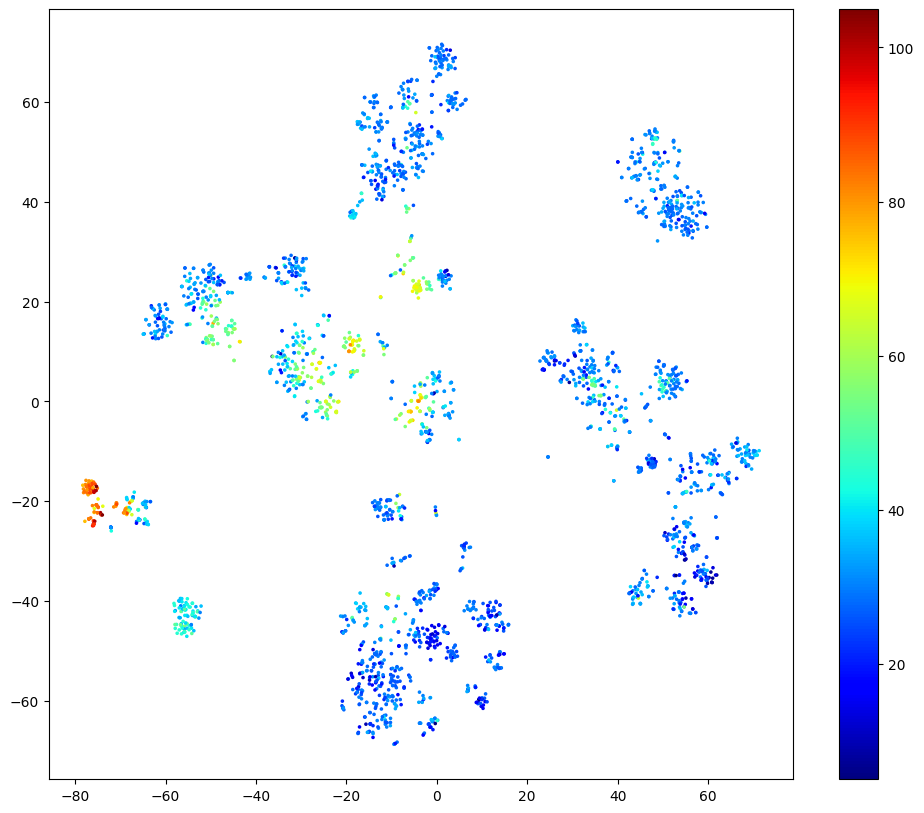

In [42]:
plt.figure(figsize=(12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], alpha=1, s = 2.5, c=y_train_to_temp, cmap='jet')
plt.colorbar()